In [387]:
# https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/
# hamiltonian monte carlo, implementation 1:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [466]:
# https://www.mcmchandbook.net/HandbookChapter5.pdf | 5.2.3.3 The Leapfrog Method
def leapfrog(q, p, Vdq, eps):
    p -= 0.5 * eps * Vdq(q)
    
    q.detach_()
    q += eps * p
    
    p -= 0.5 * eps * Vdq(q)
    return [q, p]

In [467]:
# kinetic energy
def K(pi, p, q):
    return 0.5 * (p.transpose(-1, 0)  @ p)

# potential energy at point p for distribution pi
def V(pi, q):
    return pi(q)

# closure
def mkPiVdq(pi):
    def vdq(q):
        q.detach_()
        q.requires_grad_()
        vcur = V(pi, q)
        vcur.backward()
        return q.grad
    return vdq

acceptance ratio: 0.65


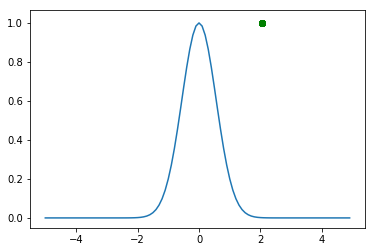

In [470]:
# pi(q): probability distribution over |R^2
# piH(q, p) = pi_pq(p|q) pi(p)
# H = - log piH(q, p) = - log pi_pq(p|q) - log pi(q)
# H =                   - K              - V
# dq/dt =  dH/dp
# dp/dt = -dH/dq 
def hmc(pi, q, p):
    accept = 0
    momentum = st.norm(0, 1)
    qs = []
    for _ in range(1000):
        # H = K(pi, p, q) + V(pi, q)
        prob = -np.log(pi(q).detach().numpy()) - np.sum(momentum.logpdf(p.detach().numpy()))
        [q_new, p_new] = leapfrog(q, p, mkPiVdq(pi), 1.0)
        
        # for time reversal
        p_new = -p_new
        prob2 = -np.log(pi(q_new).detach().numpy()) - np.sum(momentum.logpdf(p_new.detach().numpy()))
        
        if np.random.rand() < prob2 / prob:
            q = q_new
            p = p_new
            accept += 1
        qs.append(q.detach().numpy())
    print("acceptance ratio: %4.2f" % (accept / len(qs)))
    return np.array(qs)


def prob(x):
    return torch.pow(5.0, -(x[0] * x[0]))

points = hmc(prob, torch.tensor([2.0]), torch.tensor([0.1]))
plt.scatter(points, [1 for _ in range(len(points))], c='g')
xs = np.arange(-5, 5, 0.1)
ys = [prob(torch.tensor([x])) for x in xs]

plt.plot(xs, ys)

tensor([1., 1.]) tensor([0., 1.])
tensor([1., 1.]) tensor([-0.5000, -0.5000])
tensor([1.0625, 1.5625]) tensor([-0.2976, -0.4376])
tensor([1.0625, 1.5625]) tensor([-0.2976, -0.4376])
tensor([1.1994, 2.2344]) tensor([-0.1865, -0.3474])
tensor([1.1994, 2.2344]) tensor([-0.1865, -0.3474])
tensor([1.3829, 2.9932]) tensor([-0.1272, -0.2753])
tensor([1.3829, 2.9932]) tensor([-0.1272, -0.2753])
tensor([1.5982, 3.8208]) tensor([-0.0932, -0.2228])
tensor([1.5982, 3.8208]) tensor([-0.0932, -0.2228])
tensor([1.8369, 4.7041]) tensor([-0.0720, -0.1845])
tensor([1.8369, 4.7041]) tensor([-0.0720, -0.1845])
tensor([2.0935, 5.6335]) tensor([-0.0580, -0.1560])
tensor([2.0935, 5.6335]) tensor([-0.0580, -0.1560])
tensor([2.3646, 6.6019]) tensor([-0.0481, -0.1342])
tensor([2.3646, 6.6019]) tensor([-0.0481, -0.1342])
tensor([2.6477, 7.6038]) tensor([-0.0408, -0.1173])
tensor([2.6477, 7.6038]) tensor([-0.0408, -0.1173])
tensor([2.9411, 8.6351]) tensor([-0.0353, -0.1038])
tensor([2.9411, 8.6351]) tensor([-0.03

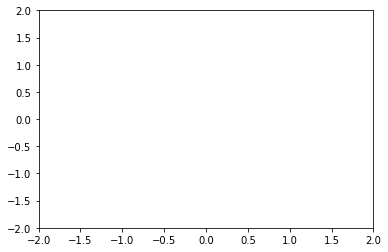

In [481]:
def gravity_simulation():
    def gravitation_potential(q): return -1.0 / torch.norm(q)
    def gravitational_force(q):
        qnorm = q.norm()
        qdir = q / qnorm
        f =  qdir / qnorm
        print(q, f)
        return f
    def gravitation_potential_dq(q):
        q.detach_()
        q.requires_grad_()
        vcur = gravitation_potential(q)
        vcur.backward()
        print(q, q.grad)    
        return q.grad

    q = torch.tensor([1.0, 1.0])
    p = torch.tensor([0.0, 1.0])
    qs = [q.detach().numpy()]
    print(q, p)
    for i in range(10):
        [q, p] = leapfrog(q, p, gravitational_force, 1.0 / 2.0)

        qs.append(q.detach().numpy())
    qs = np.array(qs)
    plt.scatter(qs[:, 0], qs[:, 1])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

gravity_simulation()